In [1]:
# Import required libraries
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, kpss




In [2]:
# Set the start and end date for data
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 1, 31)
stock_symbol = 'NVDA'

# Download stock data
stock = yf.download(stock_symbol, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


              Open    High     Low   Close  Adj Close     Volume  Log Price  \
Date                                                                          
2023-01-03  14.851  14.996  14.096  14.315  14.305582  401277000   2.660650   
2023-01-04  14.567  14.853  14.241  14.749  14.739295  431324000   2.690517   
2023-01-05  14.491  14.564  14.148  14.265  14.255614  389168000   2.657151   
2023-01-06  14.474  15.010  14.034  14.859  14.849225  405044000   2.697948   
2023-01-09  15.284  16.056  15.141  15.628  15.617718  504231000   2.748406   

            Log Returns  
Date                     
2023-01-03          NaN  
2023-01-04     0.029867  
2023-01-05    -0.033366  
2023-01-06     0.040797  
2023-01-09     0.050458  


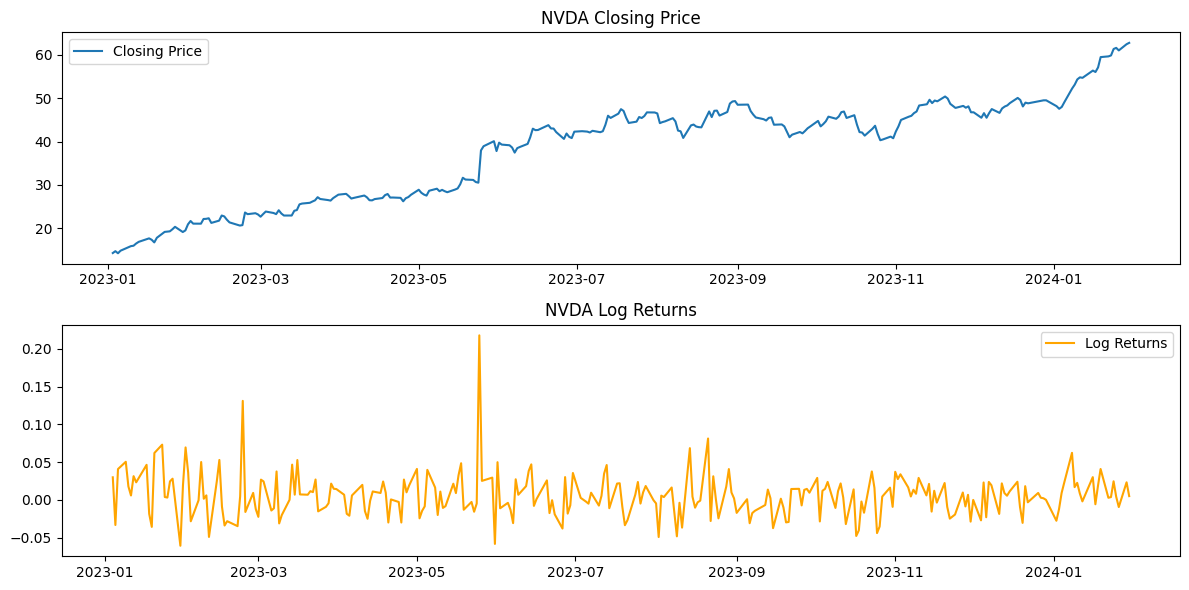

In [3]:
# Apply log transformation to the adjusted close price
stock['Log Price'] = np.log(stock['Adj Close'])

# Calculate log returns as the difference of log prices
stock['Log Returns'] = stock['Log Price'].diff()

# Check if 'Log Returns' is created successfully
print(stock.head())  # Display the first few rows to verify

# Extract the log returns as a numpy array and calculate the length
Y = stock['Log Returns'].dropna().values  # Drop any NaN values before use
T = len(Y)  # Length of time series after dropping NaN values

# Plot the closing prices and log returns for visual inspection
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(stock['Adj Close'], label='Closing Price')
plt.title(f'{stock_symbol} Closing Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(stock['Log Returns'], label='Log Returns', color='orange')
plt.title(f'{stock_symbol} Log Returns')
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
def garch(param, *args):
    mu = param[0]
    omega = param[1]
    alpha = param[2]
    beta = param[3]
    mu1 = param[4]
    sig1 = param[5]
    mu2 = param[6]
    sig2 = param[7]
    p = param[8]
    sigma2, F1, F2, v = {}, {}, {}, {}
    GARCH_dens1, GARCH_dens2, GARCH_dens_mix = {}, {}, {}
    sigma2[0] = np.var(Y)
    Likelihood = 0
    for t in range(1, T):
        sigma2[t] = omega + alpha * ((Y[t-1] - mu) ** 2) + beta * sigma2[t-1]
        if sigma2[t] < 0:
            sigma2[t] = 1e-2
        mixture_shocks1 = np.random.normal(mu1, sig1, 1)
        mixture_shocks2 = np.random.normal(mu2, sig2, 1)
        F1[t] = Y[t] - mu - np.sqrt(sigma2[t]) * mixture_shocks1
        F2[t] = Y[t] - mu - np.sqrt(sigma2[t]) * mixture_shocks2
        v[t] = sigma2[t]
        GARCH_dens1[t] = (1/2) * np.log(2 * np.pi) + (1/2) * np.log(v[t]) + (1/2) * (F1[t] / v[t])
        GARCH_dens2[t] = (1/2) * np.log(2 * np.pi) + (1/2) * np.log(v[t]) + (1/2) * (F2[t] / v[t])
        u = np.random.uniform(0, 1, 1)
        GARCH_dens_mix[t] = (u <= p) * GARCH_dens1[t] + (u > p) * GARCH_dens2[t]
        Likelihood += GARCH_dens_mix[t]

    return Likelihood

def garch_path(params, *args):
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    mu1 = params[4]
    sig1 = params[5]
    mu2 = params[6]
    sig2 = params[7]
    p = params[8]
    sigma2, path = {}, {}
    sigma2[0] = np.var(Y)
    path[0] = np.array([Y[0]])
    for t in range(1, T):
        sigma2[t] = omega + alpha * ((Y[t-1] - mu) ** 2) + beta * sigma2[t-1]
        if sigma2[t] < 0:
            sigma2[t] = 1e-2
        mixture_shocks1 = np.random.normal(mu1, sig1, 1)
        mixture_shocks2 = np.random.normal(mu2, sig2, 1)
        u = np.random.uniform(0, 1, 1)
        mixture_shocks = (u <= p) * mixture_shocks1 + (u > p) * mixture_shocks2
        path[t] = mu + np.sqrt(sigma2[t]) * mixture_shocks

    return path, sigma2

In [5]:
# Initial parameter guess
param0 = np.array([np.mean(Y), np.var(Y) / 1600, 0.06, 0.78, 0.04, 0.82, 0.002, 0.92, 0.02, 1.12, 0.68])


# Optimize parameters using maximum likelihood estimation
results = minimize(garch, param0, method='BFGS', tol=1e-2, options={'disp': True})
param_star = results.x  # Optimized parameters


         Current function value: -2827.825678
         Iterations: 1
         Function evaluations: 228
         Gradient evaluations: 18


c:\Users\56111\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_minimize.py:726: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


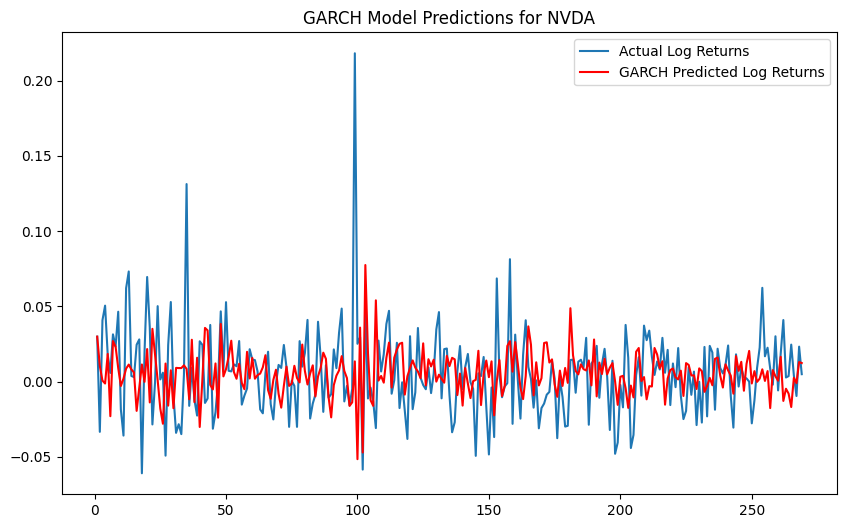

RMSE value is: 0.03232779455370253


In [6]:
# Generate GARCH-predicted path and volatility
path, vol = garch_path(param_star, Y, T)
Y_GARCH = np.array(list(path.values()))
timevec = np.linspace(1, T, T)

# Plot actual log returns vs. GARCH-predicted log returns
plt.figure(figsize=(10, 6))
plt.plot(timevec, Y, label='Actual Log Returns')
plt.plot(timevec, Y_GARCH, label='GARCH Predicted Log Returns', color='red')
plt.title(f'GARCH Model Predictions for {stock_symbol}')
plt.legend()
plt.show()

# Calculate RMSE between actual and GARCH-predicted returns
RMSE = np.sqrt(np.mean((Y_GARCH - Y) ** 2))
print(f'RMSE value is: {RMSE}')


In [7]:
S = T

In [ ]:
def kalman_smoother(params, *args):
    # initialize params
    Z = params[0]
    T = params[1]
    H = params[2]
    Q = params[3] 
    # initialize vector values:
    u_predict,  u_update,  P_predict, P_update, v, F = {},{},{},{},{},{}
    u_update[0] = Y[0]
    u_predict[0] = u_update[0] 
    P_update[0] = np.var(Y)/4 
    P_predict[0] =  T*P_update[0]*np.transpose(T)+Q  
    for s in range(1, S):
        F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
        v[s]=Y[s-1]-Z*u_predict[s-1]   
        u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
        u_predict[s] = T*u_update[s]
        P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
        P_predict[s] = T*P_update[s]*np.transpose(T)+Q
    
    u_smooth, P_smooth = {}, {}
    u_smooth[S-1] = u_update[S-1]
    P_smooth[S-1] = P_update[S-1]    
    for t in range(S-1, 0, -1):
        u_smooth[t-1] = u_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(u_smooth[t]-T*u_update[s])
        P_smooth[t-1] = P_update[t] + P_update[t]*np.transpose(T)/P_predict[t]*(P_smooth[t]-P_predict[t])/P_predict[t]*T*P_update[t]
    
    # del u_update[-1]
    smooth_path = u_smooth
    return smooth_path 

In [8]:
def kalman_filter(param,*args):
    # initialize params
    Z = param[0]
    T = param[1]
    H = param[2]
    Q = param[3]
    # initialize vector values:
    u_predict,  u_update,  P_predict, P_update, v, F = {},{},{},{},{},{}
    u_update[0] = Y[0]
    u_predict[0] = u_update[0] 
    P_update[0] = np.var(Y)/4 
    P_predict[0] =  T*P_update[0]*np.transpose(T)+Q  
    Likelihood = 0
    for s in range(1, S):
        F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
        v[s]= Y[s-1]-Z*u_predict[s-1]   
        u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
        u_predict[s] = T*u_update[s]
        P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
        P_predict[s] = T*P_update[s]*np.transpose(T)+Q
        Likelihood += (1/2)*np.log(2*np.pi)+(1/2)*np.log(abs(F[s]))+(1/2)*np.transpose(v[s])*(1/F[s])*v[s]      
    
    return Likelihood

In [9]:
param0 = np.array([1.05, 0.96, np.var(Y) / 200, np.var(Y) / 100])
results = minimize(kalman_filter, param0, method='BFGS', tol=1e-2, options={'disp': True})

# Smooth and visualize the estimated path
param_star = results.x
path = kalman_smoother(param_star, Y, S)
sorted_path = dict(sorted(path.items()))
Y_kalmanFilter = sorted_path.values()

# Time vector for plotting
timevec = np.linspace(1, S, S)
plt.title('Kalman Filter Stock Price Prediction: ' + stock_symbol)
plt.plot(timevec, Y_kalmanFilter, 'r', label='Kalman Filter Predictions')
plt.plot(timevec, Y, 'b:', label='Actual Prices')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Price')

# Calculate RMSE
kalman_values = list(Y_kalmanFilter)
RMSE = np.sqrt(np.mean((np.array(kalman_values) - Y) ** 2))
print('RMSE value is: $', RMSE)

plt.show()

c:\Users\56111\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_minimize.py:726: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -180.817707
         Iterations: 3
         Function evaluations: 332
         Gradient evaluations: 65


NameError: name 'kalman_smoother' is not defined